# Comparing Proportional Selection and SUS Selection
In this notebook, I will compare the results of using proportional selection, SUS selection, and tournament selection on the 2D step problem.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

from leap_ec.algorithm import generational_ea
from leap_ec.individual import Individual
from leap_ec.representation import Representation
import leap_ec.ops as ops
from leap_ec import probe
from leap_ec.global_vars import context

from leap_ec.real_rep.problems import StepProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

In [8]:
MAX_GEN = 10
POP_SIZE = 10
NUM_ITER = 50
BOUNDS = [[-5.12, 5.12]]*30

In [9]:
prop_file = open('./proportional_stats.csv', 'w')
prop_stats_probe = probe.FitnessStatsCSVProbe(stream=prop_file, context=context)
for i in tqdm(range(NUM_ITER)):
    prop_stats_probe.bsf_ind = None
    ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                         problem=StepProblem(maximize=True),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS)
                         ),
                         pipeline=[
                             ops.proportional_selection(offset='pop-min'),
                             ops.clone,
                             ops.uniform_crossover,
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POP_SIZE),
                             prop_stats_probe
                         ])
    list(ea);
prop_file.close()

100%|██████████| 50/50 [00:00<00:00, 66.59it/s]


In [10]:
sus_file = open('./SUS_stats.csv', 'w')
sus_stats_probe = probe.FitnessStatsCSVProbe(stream=sus_file, context=context)
for i in tqdm(range(NUM_ITER)):
    sus_stats_probe.bsf_ind = None
    ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                         problem=StepProblem(maximize=True),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS)
                         ),
                         pipeline=[
                             ops.sus_selection(n=4, offset='pop-min'),
                             ops.clone,
                             ops.uniform_crossover,
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POP_SIZE),
                             sus_stats_probe
                         ])
    list(ea);
sus_file.close()

100%|██████████| 50/50 [00:00<00:00, 69.21it/s]


In [11]:
import pandas as pd
from scipy import stats
import numpy as np

prop_df = pd.read_csv('proportional_stats.csv')
sus_df = pd.read_csv('SUS_stats.csv')

prop_df_step = prop_df.groupby('step').mean()
sus_df_step = sus_df.groupby('step').mean()

sus_df_step.to_csv('SUS_avg_stats.csv')
prop_df_step.to_csv('prop_avg_stats.csv')

prop_bsf = prop_df_step[' bsf'].values
sus_bsf = sus_df_step[' bsf'].values

In [12]:
prop_conf_up = []
prop_conf_down = []
sus_conf_up = []
sus_conf_down = []
for i in range(MAX_GEN):
    prop_step_data = prop_df[prop_df['step'] == i][' bsf'].values
    sus_step_data = sus_df[sus_df['step'] == i][' bsf'].values
    prop_int_up, prop_int_down = stats.t.interval(0.95, len(prop_step_data)-1, loc=prop_bsf[i], scale=stats.sem(prop_step_data)) 
    sus_int_up, sus_int_down = stats.t.interval(0.95, len(sus_step_data)-1, loc=sus_bsf[i], scale=stats.sem(sus_step_data))
    prop_conf_up.append(prop_int_up)
    prop_conf_down.append(prop_int_down)
    sus_conf_up.append(sus_int_up)
    sus_conf_down.append(sus_int_down)
    
print(prop_conf_up[0:10])
print(prop_conf_down[0:10])
print(sus_conf_up[0:10])
print(sus_conf_down[0:10])

[12.438588297168632, 18.51505102089606, 23.4284255377639, 27.37331020268419, 31.12141697053447, 35.27522549928373, 38.14948870880471, 41.534229098762715, 44.3711540417283, 48.99128563842674]
[18.121411702831367, 24.364948979103943, 28.8915744622361, 33.22668979731581, 36.998583029465536, 41.044774500716265, 44.090511291195284, 47.42577090123728, 50.1088459582717, 54.608714361573256]
[13.37256846764353, 20.371320843635175, 24.99467592582371, 31.576446887419607, 36.888736405700406, 40.4784270447266, 44.123602164762886, 47.7476341161627, 51.53656318104049, 55.940187121954835]
[19.027431532356466, 26.268679156364826, 31.565324074176292, 37.66355311258039, 42.43126359429959, 46.2415729552734, 49.67639783523711, 53.0523658838373, 56.903436818959506, 61.25981287804517]


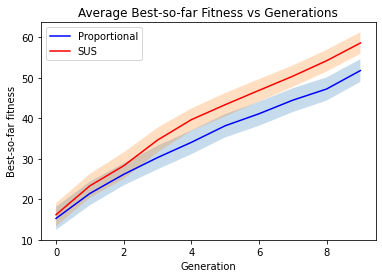

In [14]:
steps = list(range(MAX_GEN))
plt.plot(steps, prop_bsf, color='blue', label='Proportional')
plt.fill_between(steps, prop_conf_up, prop_conf_down, alpha=0.25)
plt.plot(steps, sus_bsf, color='red', label='SUS')
plt.fill_between(steps, sus_conf_up, sus_conf_down, alpha=0.25)
plt.legend()
plt.ylabel('Best-so-far fitness')
plt.xlabel('Generation')
plt.title('Average Best-so-far Fitness vs Generations')
plt.savefig('prop_vs_sus_bsf_conf95.png')

plt.show()
